In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import sys
import datetime
import scipy.optimize as optimize

In [2]:
printDebug = False

In [4]:
import YC_local

In [5]:
import sys
sys.path.append('dist')
import YC_ppy

In [6]:
class poolData:
    def __init__(self, htm, fn=None):
        
        self.dn = YC_local.descNames()
        self.servicer_code = self.dn.servicer_code
        self.servicer_name = self.dn.servicer_name
        self.work_cn_full = self.dn.work_cn_full
        self.bk_short = self.dn.bk_short
        self.bk_short_disc = self.dn.bk_short_disc
        
        self.HTmodel = htm
        self.poolFile = fn

        self.countCut = -1
        self.ageCut = -1
        self.dateCut = datetime.datetime.strptime('2022-01-01', '%Y-%m-%d')
        
        self.df_short = None
        self.df0 = None
        self.dfx = None
        
        self.initPoolData()

        
        
        if fn != None:
            self.readPoolData()
        
            
    def initPoolData(self):
        f0 = 'media-effect2.csv'
        dfmd = pd.read_csv(f0)
        dfmd = dfmd.dropna()
        dfmd['date'] = pd.to_datetime(dfmd['date'])        
        self.dfmd = dfmd
        
        f0 = 'm-delay-spread.csv'
        dfds = pd.read_csv(f0)
        dfds = dfds.dropna()
        dfds['date'] = pd.to_datetime(dfds['date'])        
        self.dfds = dfds
            
    def readShortFile(self, fn):
        self.poolFile = fn
        self.df_short = pd.read_csv(fn)
        self.df0 = self.processShortDF(self.df_short)
        self.dfx = self.df0[self.dn.calib_cn_full]
        
    def saveShortPoolFile(self, fn):
        self.df_short.to_csv(fn, index=None)

    def processShortDF(self, df):
        
        file0 = self.poolFile
        
        ht = self.HTmodel.HT_months
        
        countCut = self.countCut
        ageCut = self.ageCut
        dateCut = self.dateCut
        
        dfmd = self.dfmd
        dfds = self.dfds
        
        bk_short = self.bk_short
        bk_short_disc = self.bk_short_disc
        
        cn1_short = df.columns
        for c in bk_short:
            if c in cn1_short:
                x = 1
            else:
                if c in bk_short_disc:
                    df[c] = 'all'
                else:
                    df[c] = -5000
    
        # fix features
        df1 = df
        the_dates = list(df1['date'].unique())
        df1['me'] = 0
        df1['m21'] = 0
        df1['adm15'] = 0
        for d in the_dates:
            me = list(dfmd.loc[dfmd["date"] == d, "ME"])[0]
            df1['me'][df1['date']==d] = me
            me = list(dfds.loc[dfds["date"] == d, "m21"])[0]
            df1['m21'][df1['date']==d] = me
            me = list(dfds.loc[dfds["date"] == d, "adm15"])[0]
            df1['adm15'][df1['date']==d] = me
            df1['b_me'] = ((2*df1['me'] + 0.5).astype(int)/2).astype(int)
            df1['b_spread'] = 0
            df1['b_inc'] = (2*df1['incentive'] + 0.5).astype(int)/2

        dfwork = df1
        if printDebug:
            print(file0, 'after reading...', dfwork.shape)
        dfwork = dfwork.dropna()
        if printDebug:
            print(file0, 'after dropna...', dfwork.shape)
        dfwork = dfwork[ dfwork['count'] > countCut ]
        if printDebug:
            print(file0, 'after countCut...', countCut, dfwork.shape)
        dfwork = dfwork[ dfwork['age'] > ageCut ]
        if printDebug:
            print(file0, 'after ageCut...', ageCut, dfwork.shape)
    
        dfwork['date'] = pd.to_datetime(dfwork['date'])
    
        dfwork = dfwork[ dfwork['date'] < dateCut ]
        if printDebug:
            print('dateCut...', dateCut, dfwork.shape)

        dfwork['month'] = pd.DatetimeIndex(dfwork['date']).month
        dfwork['ht'] = 0
        for i in range(12):
            dfwork['ht'][dfwork['month'] == i+1 ] = ht[i]
        
        dfwork['ramp'] = self.HTmodel.getAgeMulti(np.array(dfwork['age']))
        dfwork['mltv'] = self.HTmodel.getLTVMulti(np.array(dfwork['ltv']))
        dfwork['rht'] = dfwork['ht'] * dfwork['ramp'] * dfwork['mltv']
        dfwork['rht'] = np.minimum(dfwork['rht'], dfwork['cpr'])
        dfwork['rf'] = dfwork['cpr'] - dfwork['rht']

        if 'corres' not in dfwork.columns:
            dfwork['corres'] = 100 - dfwork['broker'] - dfwork['retail']
        if 'PUD' not in dfwork.columns:
            dfwork['PUD'] = 100 - dfwork['single'] - dfwork['coop'] - dfwork['condo']  - dfwork['MH']
    
        dfwork = dfwork[self.work_cn_full]

        self.dfwork1 = dfwork
        
        return dfwork
        
        
runTest = 1
if runTest == 1:
    htm = YC_ppy.prepayModelHT()
    pool = poolData(htm)
    fs = 'fnma3467_short.csv'
    pool.readShortFile(fs)



C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [7]:
def cpr_to_smm(cpr):
    if cpr < 0 or cpr > 100:
        raise ValueError("CPR must be between 0 and 1 (0% to 100%).")
    smm = 1 - (1 - cpr/100) ** (1 / 12)
    return smm

def mergeCPR(c1, c2, c3):
    s1 = cpr_to_smm(c1)
    s2 = cpr_to_smm(c2)
    s3 = cpr_to_smm(c3)
    xs = (1-s1)*(1-s2)*(1-s3)
    cpr = 100 - 100 * xs**12
    return cpr

class attributeValue:
    def __init__(self, nm, sm, sv):
        self.name = nm
        self.splitMethod = sm               # 0: simple value;  1: % of base
        self.splitValue = sv
        self.v0 = 0
        self.v1 = 0
        self.v2 = 0
        self.p1 = 0.5
        self.p2 = 0.5
        self.calcFlag = 0
        
    def getValue(self):
        if self.calcFlag == 0:
            print('ERROR: not calculated yet...', self.name)
            sys.exit()
        return self.v0
    
    def reset(self):
        self.calcFlag = 0

    def updateValue(self, multi):
        self.v1 *= multi
        self.v2 *= multi
        
    def setValue(self, v0):
        self.v0 = v0
        if self.splitMethod == 0:
            self.v1 = v0 - self.splitValue
            self.v2 = v0 + self.splitValue
        else:
            self.v1 = v0 * ( 1-self.splitValue )
            self.v2 = v0 * ( 1+self.splitValue )
            
    def calcV0(self, cpr1, cpr2):
        smm1 = cpr_to_smm(cpr1)
        smm2 = cpr_to_smm(cpr2)
        self.p1 = self.p1 * (1-smm1)
        self.p2 = self.p2 * (1-smm2)
        tot = self.p1 + self.p2
        self.p1 = self.p1/tot
        self.p2 = self.p2/tot
        self.v0 = self.v1 * self.p1 + self.v2 * self.p2
        self.calcFlag = 1
        
class modelScenario:
    def __init__(self):
        self.hpa = 0.04

        dBPS = 0.25    # 25bps
        dALS = 0.1     # 10%
        
        self.wac = attributeValue('wac', 0, dBPS)
        self.cs = attributeValue('cs', 0, dBPS)
        self.dti = attributeValue('dti', 0, dBPS)
        self.sato = attributeValue('sato', 0, dBPS)
        self.als = attributeValue('als', 1, dALS)
        self.ltv = attributeValue('ltv', 1, dALS)

        self.m30y = []
        self.m15y = []

        self.future30Y = -1

    def printInfo(self):
        print(self.m30y, self.m15y, self.future30Y)
        
    def getAttr(self, attn):
        if attn == 'cs':
            return self.cs
        if attn == 'dti':
            return self.dti
        if attn == 'sato':
            return self.sato
        if attn == 'als':
            return self.als
        if attn == 'ltv':
            return self.ltv
        if attn == 'wac':
            return self.wac
        
        print('ERROR: attn unknown: ', attn)
        sys.exit()
        
    def reset(self):
        self.wac.reset()
        self.cs.reset()
        self.dti.reset()
        self.sato.reset()
        self.als.reset()
        self.ltv.reset()
        
    def setMortgateRate(self, m30, m15):
        self.m30y = m30
        self.m15y = m15
        

In [8]:
def calculate_monthly_payment(balance, wac, months):
    # monthly rate: wac in %, mRate in decimal
    mRate = wac / 1200
    # Calculate the monthly payment using the amortization formula
    if mRate == 0:  # Handle the case of 0% interest
        monthly_payment = balance / months
    else:
        monthly_payment = balance * (mRate * (1 + mRate) ** months) / ((1 + mRate) ** months - 1)
    return monthly_payment


def generate_amortization_schedule(balance, wac, months, simpleRatio=1):
    """
    Generate an amortization schedule for a fixed-rate mortgage.

    :param balance: Remaining loan balance (principal).
    :param wac: Annual interest rate (WAC) in % (e.g., 5.0 for 5%).
    :param months: Remaining loan term in months.
    :return: List of dictionaries representing the amortization schedule.
    """
    monthly_payment = calculate_monthly_payment(balance, wac, months)
    mRate = wac / 1200
    remaining_balance = balance
    amortization_schedule = []

    for month in range(1, months + 1):
        # Calculate interest and principal for the current month
        interest_payment = remaining_balance * mRate
        principal_payment = monthly_payment - interest_payment

        pct = (remaining_balance-principal_payment)/remaining_balance
        # Update the remaining balance
        remaining_balance -= principal_payment
        # Append the details to the amortization schedule

        if simpleRatio == 1:
            amortization_schedule.append(pct)
        else:
            amortization_schedule.append({
                "Month": month,
                "Payment": monthly_payment,
                "Principal": principal_payment,
                "Interest": interest_payment,
                "Remaining Balance": remaining_balance,
                "pctRemaining":pct
            })

    return amortization_schedule

def generate_ME(dt0, age, m30y, nMonth):
    ### read FH_PMMS upto dt0, and connect with m30y --> ME...not implemented yet
    me = [0] * nMonth
    return me

def add1month(dt):
    yr = dt.year
    mo = dt.month
    if mo == 12:
        yr += 1
        mo = 1
    else:
        mo += 1
    return datetime.datetime(yr, mo, 1)

runTest = 0
if runTest == 1:
    balance = 300000  # Remaining loan balance
    wac = 5.5  # 5.5% annual interest rate (WAC)
    months = 350  # Remaining loan term in month

    # Calculate the monthly payment
    monthly_payment = calculate_monthly_payment(balance, wac, months)
    print(f"Monthly Principal and Interest Payment: ${monthly_payment:.2f}")

    # Generate and print the amortization schedule
    amortization_schedule = generate_amortization_schedule(balance, wac, months)
    n = 335
    for entry in amortization_schedule[n:n+12]:  # Print the n to n+12 months
        print(entry)


In [9]:
######################################################
#   model projection
######################################################
class modelProjection:
    def __init__(self, htm, rfm, mds):
        
        self.dn = rfm.dn
        self.htModel = htm
        self.refiModel = rfm
        self.calib_list = []

        self.modelScen = mds

        self.ctModel = YC_ppy.prepayModelCurtail()
        
        self.dfx = None
        self.df0 = None
        self.w = 0
        self.W = 0
        self.Y = 0
        self.X = 0
        
        self.loanMode = False
        
        self.mds = None
        
        self.shiftA = -0.5
        self.shiftB = -0.5
        self.shiftAv = 1
        self.shiftBv = 1
        self.shift0v = 1
        self.baseX   = 0
        self.refiCPR = 0
        self.m30y    = 5
        
    def setREFImodel(self, refim):
        self.refiModel = refim
        if self.calib_list != []:
            self.refiModel.setCalibList(self.calib_list)
        
    def setCalibList(self, cl):
        self.calib_list = cl
        if self.refiModel != None:
            self.refiModel.setCalibList(cl)
            
    def setData(self, df0):

        self.df0 = df0
        self.dfx = df0[self.dn.calib_cn_full]
        
        dfx = self.dfx
        
        dataset=np.array(dfx)
        n = dfx.shape[1]-1
        self.W = dataset[:,0]
        self.Y = dataset[:,n]
        self.X = dataset[:,1:n]

        self.calcWeight()
        
    def calcWeight(self):
        W = self.W
        uniform_weight = 0.001
        W2 = np.array( [W.max()] * len(W))
        W3 = (W + W2 * uniform_weight)/(1+uniform_weight)
        w = W3/W3.sum()
        self.w = w
        return w

    def calculateRefiCPR(self, df0):
        self.setData(df0)
        ypred = self.predict2(self.X)
        return ypred
    
    def plotPoolHist(self, df0):
        if True:
            ax = plt.gca()
            df0.plot(kind='line',x='date',y='rf', ax=ax)
            df0.plot(kind='line',x='date',y='prf',color = 'red', ax=ax)
            print('plotting...', f0)
            plt.show()
    
            ax = plt.gca()
            df0.plot(kind='line',x='date',y='cpr', ax=ax)
            df0.plot(kind='line',x='date',y='pcpr',color = 'red', ax=ax)
            print('plotting...', f0)
            plt.show()
    
    def runPoolHistPrepay(self, pool):

        ypred = self.calculateRefiCPR(pool.df0)
        df0 = self.df0

        df0['prf'] = ypred
        df0['pcpr'] = df0['prf'] + df0['rht']
        
        if printDebug:
            
            print(df0.shape)
            print(len(self.X))
            print(len(ypred))
            
            self.plotPoolHist(df0)

    def loadRFPS(self, fn=None):
        self.refiModel.loadRFPS(fn)
    
    def predict2(self, X):
        
        ypred = []
        
        n_bucket = self.refiModel.n_bucket
        allGrids = self.refiModel.allGrids
        
        saveShiftImpact = (X.shape[0] == 1)
        
        for i in range(X.shape[0]):
            y = 1
            x = X[i]
            s = 0
            for j in range(n_bucket):
                grid0 = allGrids[j]
                if grid0.isIncentive == False:
                    js = allGrids[j].x_start
                    if ( allGrids[j].discrete and (allGrids[j].noShift==False) ) or (allGrids[j].isSpread) :
                        js2 = js + allGrids[j].n_grid
                        shift = allGrids[j].getShift(x[js:js2])
                        s = s + shift
                        
                        runDebug = 0
                        if runDebug == 1 and saveShiftImpact:
                            if shift != 0:
                                print('....check getShift', s, shift, grid0.bname)

            for j in range(n_bucket):
                grid0 = allGrids[j]
                js = allGrids[j].x_start
                if allGrids[j].discrete:
                    js2 = js + allGrids[j].n_grid
                    y = y * allGrids[j].getV(x[js:js2])
                else:
                    x1 = x[js]
                    v = -999
                    if grid0.isIncentive :
                        x1 += s
                        if saveShiftImpact:
                            self.shiftAv = allGrids[j].getV(x1+self.shiftA) ### for NY
                            self.shiftBv = allGrids[j].getV(x1+self.shiftB) ### for investor
                            self.shift0v = allGrids[j].getV(x1) 
                            self.baseX   = x1
                            v = self.shift0v
                            #print('---------debug predict2:incentive ', i, j, self.shiftA, self.shiftB, s, self.shiftAv, self.shiftBv, v)
                    if v == -999:
                        v = allGrids[j].getV(x1)
                    y = y * v
            ypred.append(y)
        
        return ypred    
    
    def setRFshift(self):
        allGrids = self.refiModel.allGrids
        for j in range(len(allGrids)):
            grid0 = allGrids[j]
            for k in range(len(grid0.grid)):
                if grid0.noShift:
                    continue
                if grid0.grid[k] == 'NY':
                    self.shiftA = grid0.grid_s[k]
                if grid0.grid[k] == 'invest':
                    self.shiftB = grid0.grid_s[k]

    def printRFshift(self):
        self.refiModel.printRFshift()
    
    def updateWAC(self, df0):
        grid0 = self.refiModel.getIncentive()
        v1 = grid0.getV(self.baseX+self.modelScen.wac.v1-self.wac)
        v2 = grid0.getV(self.baseX+self.modelScen.wac.v2-self.wac)
        v0 = self.shift0v
        
        if self.refiCPR > 0:
            cpr1 = self.refiCPR * v1/v0
            cpr2 = self.refiCPR * v2/v0
        else:
            cpr1 = 0
            cpr2 = 0

        if printDebug:
            print('debug updateWAC: ', self.refiCPR, cpr1, cpr2)
            
        self.modelScen.wac.calcV0(cpr1, cpr2)
        df0['wac'] = self.modelScen.wac.getValue()
        df0['incentive'] = df0['wac'] - self.m30y
        return df0
    
    def updateScenAttr(self, df0, grid0, att):
        v1 = grid0.getV(att.v1)
        v2 = grid0.getV(att.v2)
        v0 = grid0.getV(att.v0)
        if self.refiCPR > 0:
            cpr1 = self.refiCPR * v1/v0
            cpr2 = self.refiCPR * v2/v0
        else:
            cpr1 = 0
            cpr2 = 0
        
        if printDebug:
            print('....debug updateScenAttr: ', cpr1, cpr2, grid0.bname, att.name)
            
        att.calcV0(cpr1, cpr2)
        v0 = att.getValue()
        df0[att.name] = v0

        return df0
        
    def updateNewStats(self, df0):
        
        df0 = self.updateWAC(df0)

        for attn in ['cs','dti','sato','als','ltv']:
            grid0 = self.refiModel.getGrid(attn)
            att = self.modelScen.getAttr(attn)
            df0 = self.updateScenAttr(df0, grid0, att)
            df0[attn] = att.getValue()

        return df0
    
    def updateHT(self, dfwork):
        
        ht = self.htModel.HT_months
        
        dfwork['ramp'] = self.htModel.getAgeMulti(np.array(dfwork['age']))
        dfwork['mltv'] = self.htModel.getLTVMulti(np.array(dfwork['ltv']))
        dfwork['month'] = pd.DatetimeIndex(dfwork['date']).month
        dfwork['ht'] = 0
        for i in range(12):
            dfwork['ht'][dfwork['month'] == i+1 ] = ht[i]
        dfwork['rht'] = np.where( dfwork['rht'] < 0, dfwork['ht'] * dfwork['ramp'] * dfwork['mltv'], dfwork['rht'])
        return dfwork
        
    def updateCT(self, df0):
        wam = df0['maturity'].to_list()
        cts = []
        for i in range(len(wam)):
            cts.append( self.ctModel.getCurtail(wam[i]) )
        df0['curtail'] = cts
        return df0
        
    def updateCPR(self, df0):
        ht = df0['rht'].to_list()
        rf = df0['prf'].to_list()
        ct = df0['curtail'].to_list()
        cpr = []
        for i in range(len(ht)):
            _cpr = ht[i] + rf[i] + ct[i]
            if _cpr > 90:
                _cpr = mergeCPR(ht[i], rf[i], ct[i])
            cpr.append(_cpr)
        df0['pcpr'] = cpr
        df0['cpr'] = np.where( df0['cpr']<0, df0['pcpr'], df0['cpr'])
        
        return df0
        
    def updateDiscAttr(self, df0, grid0):

        checkGN = (grid0.bname in ['b_state', 'b_occ'] )
        
        nk = len(grid0.grid)
        gns = []
        ps  = []
        smms = []
        ws = []
        for k in range(nk):
            _gn = grid0.grid[k]
            gns.append(_gn)
            _ps = grid0.grid_p[k]
            if _ps < 0:
                print('ERROR: negative ps: ', grid0.bname, _ps)
                sys.exit()
            if checkGN:
                if _gn == 'NY':
                    _ps = _ps * self.shiftAv/self.shift0v
                elif _gn == 'invest':
                    _ps = _ps * self.shiftBv/self.shift0v
            ps.append(_ps)
            
            _w = df0.iloc[0][_gn]
            ws.append(_w)
            
#        print('debug updateDiscAttr: ', grid0.bname,  ps)
            
        ps = np.array(ps)
        sps = sum(ps)/len(ps)
        ps = ps/sps
        factors = []
        for k in range(nk):
            _cpr = self.refiCPR * ps[k]
            if _cpr > 100 or _cpr < 0:
                print('...debug updateDiscAttr: ', grid0.bname, k, _cpr, self.refiCPR, ps)
                sys.exit()
            _smm = cpr_to_smm(_cpr)
            factors.append(1-_smm)
        factors = np.array(factors)
        ws = np.array(ws) * factors
        ws = ws/sum(ws) * 100
        
        for k in range(nk):
#            print('....debug update discDF0: ', k, gns[k], df0.iloc[0][gns[k]], ws[k])
            df0[gns[k]] = ws[k]
            
        return df0
    
    def updateDiscGrid(self, df0):
        allGrids = self.refiModel.allGrids
        for j in range(len(allGrids)):
            grid0 = allGrids[j]
            if grid0.discrete and not grid0.isSpread:
                df0 = self.updateDiscAttr(df0, grid0)
        return df0
    
    def runPoolPrepay(self, pool):
        
        self.setRFshift()
        
        df0 = pool.df0
        
        df_total = df0.copy()
        
        dt0 = df0['date'].max()
        df0 = df0[ df0['date']==dt0 ]

#        nt = int(df0.iloc[0]['age']) + 1
        nt = int(df0.iloc[0]['maturity']) + 1

        ### m21/adm15 ps not in used yet
        if self.modelScen.m30y == []:
            self.modelScen.m30y = [self.modelScen.future30Y] * nt
            m21 = [0] * nt
            adm15 = [ df0.iloc[0]['adm15'] ] * nt
        else:
            if len(self.modelScen.m30y) != len(self.modelScen.m15y):
                print('ERROR: modelScen m30y/m15y diff length...', len(self.modelScen.m30y), len(self.modelScen.m15y))
                sys.exit()
            if len(self.modelScen.m30y) < nt:
                print('ERROR: modelScen m30y too short...', len(self.modelScen.m30y), nt)
                sys.exit()
            
            m21 = []
            adm15 = []
            for i in range(nt):
                m21.append(self.modelScen.m30y[i+1]-self.modelScen.m30y[i])
                adm15.append(self.modelScen.m30y[i]-self.modelScen.m15y[i])
        
                
        ### calculate amortization ratio
        wac = df0.iloc[0]['wac']
        months = int(df0.iloc[0]['maturity']+0.5)
        balance = df0.iloc[0]['balance']
        count = df0.iloc[0]['count']
        age = int(df0.iloc[0]['age']+0.5)
        amortRatio = generate_amortization_schedule(1.0, wac, months)       
        ### calculate ME in the future
        me = generate_ME(dt0, age, self.modelScen.m30y, len(amortRatio))
        
        self.m30y = wac - df0.iloc[0]['incentive']
        
        for attn in ['wac','cs','dti','sato','ltv','als']:
            att = self.modelScen.getAttr(attn)
            att.setValue(df0.iloc[0][attn])
            
            if attn == 'wac':
                print('..............................debug att.setValue')
                print(att.v1, att.v2)
                
        m = 0
        refiCPR = []
        hpa = ( 1 + self.modelScen.hpa/12 )
        while m < months:
            
            self.modelScen.reset()
            
            # step 1: calculate the refiCPR:
            cpr = self.calculateRefiCPR(df0)[0]
            self.refiCPR = cpr
            
            if cpr > 100 or cpr < 0:
                print('ERROR in months: ', m, cpr)
                sys.exit()
            
            self.wac     = df0.iloc[0]['wac']
            
            # step 2: update attributes
            dt0 = add1month(dt0)
            df0['date'] = dt0
            df0['balance'] = df0['balance'] * amortRatio[m]
            df0['count'] = count
            df0['age'] = df0['age'] + 1
            df0['maturity'] = df0['maturity'] - 1
            df0['me'] = me[m]
            multi = amortRatio[m]
            df0['als'] = df0['als'] * multi
            self.modelScen.als.updateValue(multi)
            multi = amortRatio[m] / hpa
            df0['ltv'] = df0['ltv'] * multi
            self.modelScen.ltv.updateValue(multi)
            
            #df0 = self.updateNewStats(df0)
            df0 = self.updateDiscGrid(df0)
            
            df0['incentive'] = df0['wac'] - self.m30y

            ### update df0 and concat to df_total
            ### print('.....debug months: ', m, months, len(self.modelScen.m30y))
            
            if m > 0:
                ### m=0 is previous month, m=1 is the first future month
                refiCPR.append(cpr)
                df0['rf'] = cpr
                df0['prf'] = cpr
                df0['rht'] = -1
                df0['cpr'] = -1
                df0['pcpr'] = -1
                df_total = pd.concat( [df_total, df0] )
                self.m30y = self.modelScen.m30y[m-1]
                
            m += 1

        df_total = self.updateHT(df_total)
        df_total = self.updateCT(df_total)
        df_total = self.updateCPR(df_total)
            
        return refiCPR, df_total
    
runTest = 1
if runTest == 1:
    htm = YC_ppy.prepayModelHT()
    f0 = 'fnma3467_short.csv'
    pool = poolData(htm)
    pool.readShortFile(f0)
    
    mds = modelScenario()
    mds.future30Y = 4.0
    
    rfm = YC_ppy.prepayModelREFI()
    mr = modelProjection(htm, rfm, mds)
    mr.loadRFPS()
    mr.runPoolHistPrepay(pool)
    
runTest = 1
if runTest == 1:
    refi, dfy = mr.runPoolPrepay(pool)
    

C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

..............................debug att.setValue
4.495693257546809 4.995693257546809


C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yongc\Anaconda3\lib\site-packages\ipykernel_launcher.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

plotting... fnma3467_short.csv


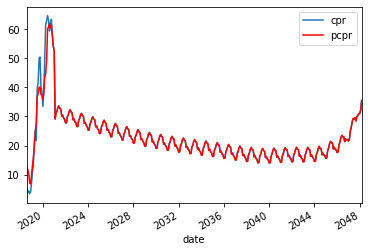

In [13]:
doThis = 1
if doThis == 1:
    if True:
        df0 = dfy
        ax = plt.gca()
        df0.plot(kind='line',x='date',y='cpr', ax=ax)
        df0.plot(kind='line',x='date',y='pcpr',color = 'red', ax=ax)
        print('plotting...', f0)
        plt.show()